In [1]:
# imports libraries
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import math
import sklearn.decomposition as dcmp
import pyaudio
import csv
import IPython

%matplotlib inline 

# Grabs the preprocessing and automatic_sync files
sys.path.append(os.path.join(os.pardir,'pythonCode'))
import preprocessing as pp
import automatic_sync as autoS
import audio

This script finds the "fractures" that I. Mantawy identfied by hearing them in the raw audio file.
Last update: Travis Thonsad 02/6/2016

In [2]:
# Estimated fracures are found first using the cropped audio sigals from I. Mantawy
fname = 'GP_B1_NL_18'

# Determines which cameras will be selected (['Bents'],['Camera Location'],['Motion #'])
filt = (['B1'],['NL'],['18']) # Selects the bent 1 camera used during motion 18

In [3]:
rawDataPath = os.path.join(os.pardir,'rawData','IM_Files')
files = glob.glob(os.path.join(rawDataPath,fname + '.wav'))
names = []
        
for name in files:
    fileName = os.path.basename(name).split(".")[0]
    names.append(fileName)
    
# Applies filter to camera names and returns only selected subset names
audioFiles = pp.getKeys(names,filt);

# Reads the .wav files from the list generted by getKeys
(names,croppedDataset) = pp.readWAV(rawDataPath,audioFiles);

Opening GP_B1_NL_18 ...


In [4]:
FsOrig = 44100 # DIFFERENT THAN THE GOPRO CAMERAS RAW OUTPUT

In [5]:
# plays the sound (checks to make sure that the sampling frequency is right)
IPython.display.Audio(croppedDataset[names[0]].T,rate=FsOrig)

In [7]:
# resample signal to be at 48 kHz
Fs = 48000
FsRatio = (Fs/FsOrig)

# Original length of the vector
print("Old Length: " + str(len(croppedDataset[names[0]])/FsOrig) + " sec")

# New length of the vector
Nsamples = np.rint(FsRatio *len(croppedDataset[names[0]]))
print("New Length: " + str(Nsamples/Fs) + " sec")

# Resamples the signal and 
reSampsignal = signal.resample(croppedDataset[names[0]],Nsamples)
croppedDataset[names[0]] = reSampsignal

Old Length: 23.707573696145126 sec
New Length: 23.7075833333 sec


In [8]:
# Grabs I. Mantawy's estimated fractures from the .csv file

csvPath = os.path.join(os.pardir,'rawData','IM_Files')
print(os.path.join(csvPath,fname + '.csv'))
fileName = glob.glob(os.path.join(csvPath,fname + '.csv')); 

fractures = list(csv.reader(open(fileName[0], 'rt'), delimiter=','))
fractures = np.array([float(i[0]) for i in fractures]) # in seconds
fracturesInd = np.array(np.rint(Fs*fractures),dtype = int) # in counts
   
print(fracturesInd) #prints the fractures in counts

..\rawData\IM_Files\GP_B1_NL_18.csv
[175623 178815 205208 220361 223149 231597 234087 240532 243191 282281
 285416 303636 306114 409968 420475 427141 428934 431835 446949 449294
 451830 456940 460024 462031]


In [9]:
# now reads in the datafile from the raw data folder
rawDataPath = os.path.join(os.pardir,'rawData')
files = glob.glob(os.path.join(rawDataPath, fname + '.wav'))
names = []
        
for name in files:
    fileName = os.path.basename(name).split(".")[0]
    names.append(fileName)

# Applies filter to camera names and returns only selected subset names
audioFiles = pp.getKeys(names,filt);
# Reads the .wav files from the list generted by getKeys
(names,rawDataset) = pp.readWAV(rawDataPath,audioFiles);

Opening GP_B1_NL_18 ...


In [10]:
#builds a new dictionary to sync
tempDict = {}
tempDict['cropped'] = croppedDataset[names[0]]
tempDict['raw'] = rawDataset[names[0]]

In [11]:
# determines the offset between the cut signal from I. Mantawy and the raw audio in the rawData folder
# finds the relative offsets between the cameras in counts

offsets = autoS.find_offset(tempDict,'raw',['cropped'])
print(offsets) # prints the offsets in counts

{'raw': 0, 'cropped': 1436570}


In [12]:
# computes new fracture indicies based on cross-correlation offset
rawFractureInd = fracturesInd + offsets['cropped']
print(rawFractureInd)

[1612193 1615385 1641778 1656931 1659719 1668167 1670657 1677102 1679761
 1718851 1721986 1740206 1742684 1846538 1857045 1863711 1865504 1868405
 1883519 1885864 1888400 1893510 1896594 1898601]


In [13]:
out = rawFractureInd.tolist()

fpath = os.path.join(os.pardir,'rawData', fname + '.csv')
print(fpath)
a = csv.writer(open(fpath, 'w'), delimiter=',')
for value in out:
    print(value)
    a.writerow([value])

..\rawData\GP_B3_SL_19.csv
1308941
1310843
1351862
1354556
1374331
1376375
1480596
1482502
1501710
1504754
1534912
1536949
1566979
1568832
1664804
1666861
1845199
1847276
1872315
1874327
1901178
1903150
2070712
2072636
2100969


C:\Users\Travis\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7027: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


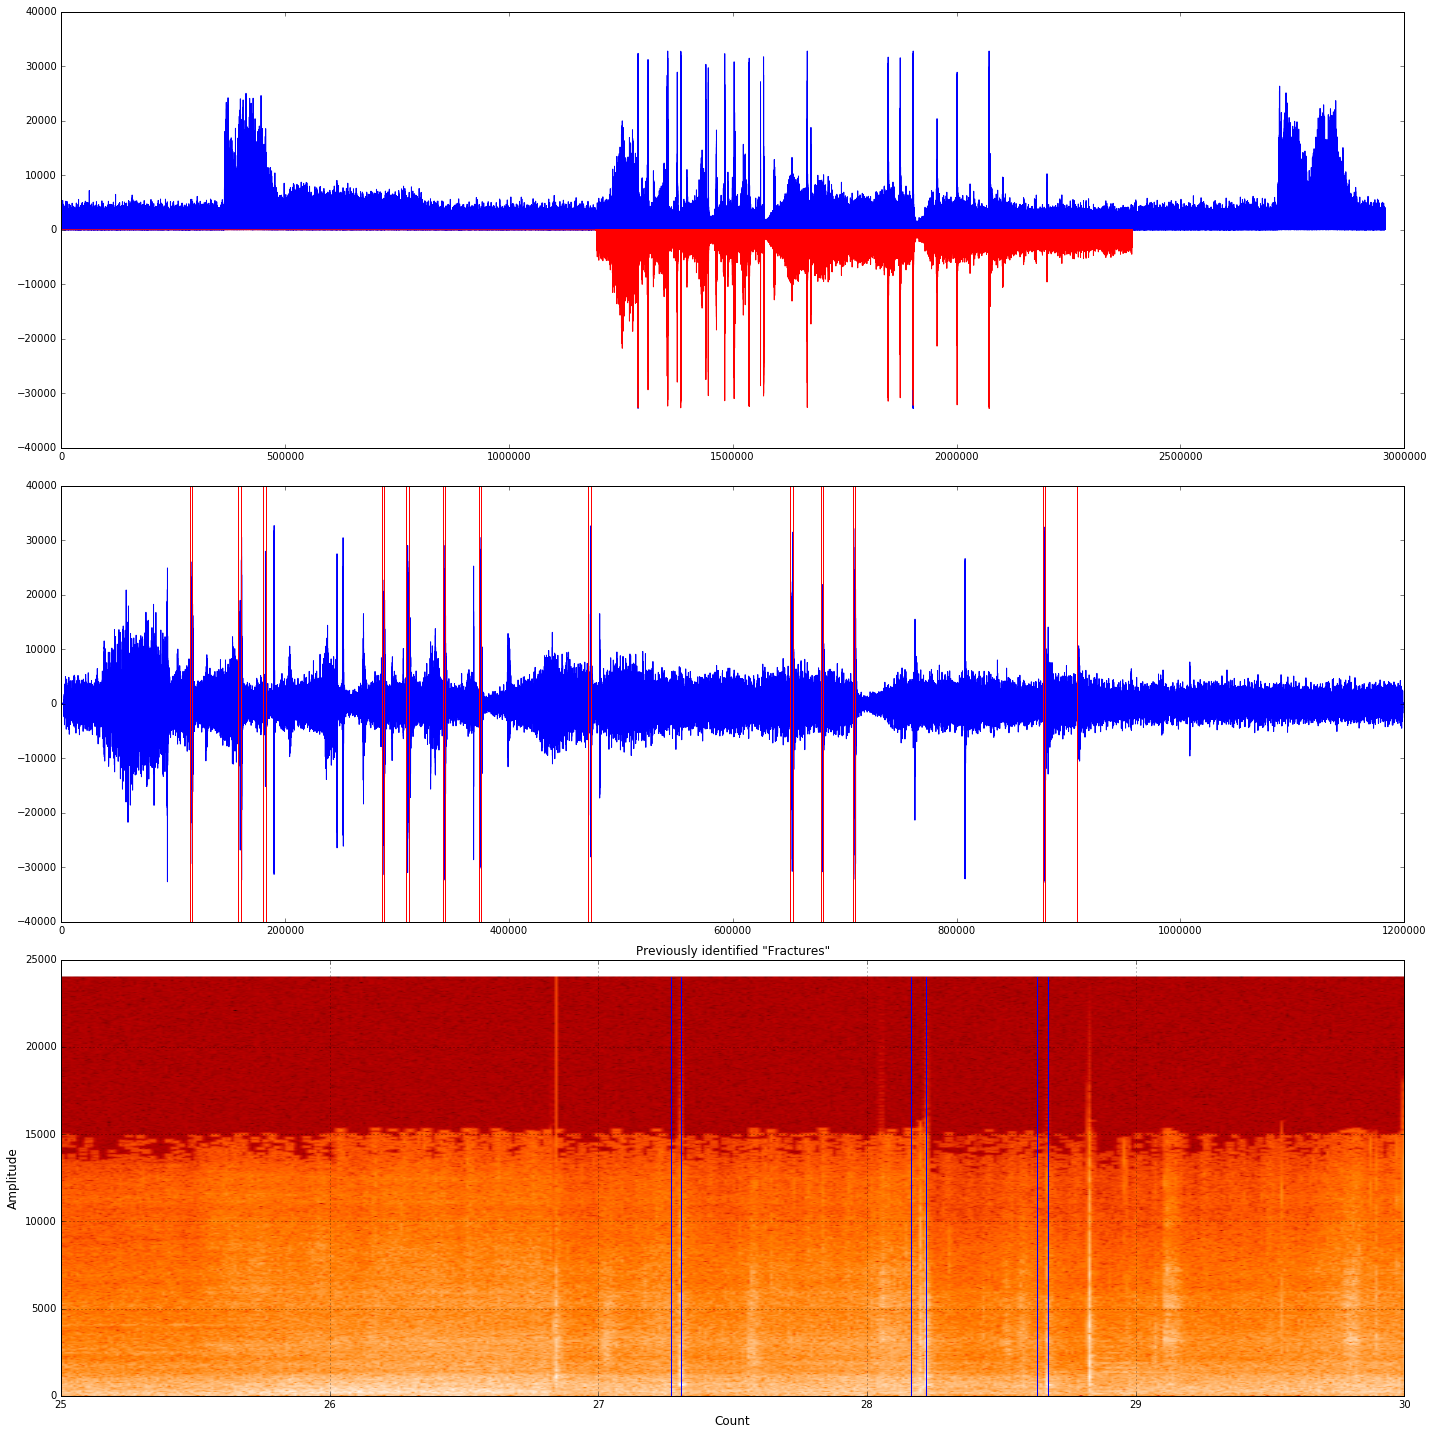

In [49]:
# plots everything to check
fig1 = plt.figure(figsize = (20,20))

plt.subplot(3,1,1)
plt.plot(abs(rawDataset[names[0]][:,0]),'b')
plt.plot(-abs(np.concatenate([np.zeros(offsets['cropped']),croppedDataset[names[0]][:,0]])),'r')

plt.subplot(3,1,2)
plt.plot(croppedDataset[names[0]][:,0],'b')
for ii in range(len(rawFractureInd)):
    plt.plot([fracturesInd[ii],fracturesInd[ii]],[-40000,40000],'r')

plt.subplot(3,1,3)
#plt.plot(rawDataset[names[0]][:,0],'b')
plt.specgram(rawDataset[names[0]][:,0], NFFT=1024, Fs=Fs, noverlap=512, cmap=plt.cm.gist_heat)
for ii in range(len(rawFractureInd)):
    plt.plot([rawFractureInd[ii]/Fs,rawFractureInd[ii]/Fs],[0,Fs/2],'b')
plt.xlim((25,30))    


plt.xlabel('Count',fontsize = 12)
plt.ylabel('Amplitude',fontsize = 12)  
#plt.xlim((offsets['cropped'],offsets['cropped']+len(croppedDataset[names[0]][:,0])))
plt.draw()
plt.title('Previously identified "Fractures"')
plt.grid()

fig1.tight_layout() 

#plt.savefig('IMfractures.pdf',format = 'pdf', transparent = True)

In [36]:
np.diff(rawFractureInd)

array([  3192,  26393,  15153,   2788,   8448,   2490,   6445,   2659,
        39090,   3135,  18220,   2478, 103854,  10507,   6666,   1793,
         2901,  15114,   2345,   2536,   5110,   3084,   2007])

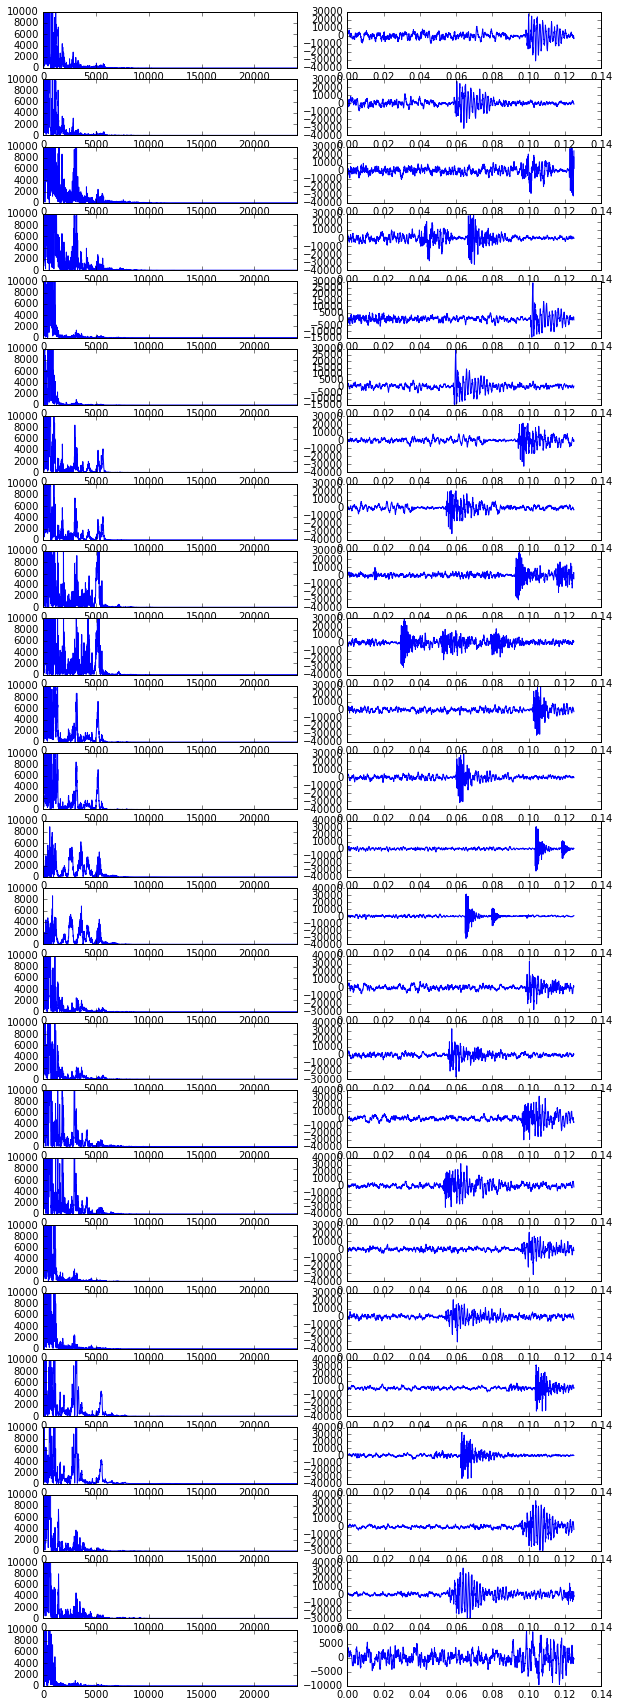

In [50]:
# grabs small chunks of the signal around each identified fracture
plt.figure(figsize = (10,30))

clipLength = 6000 #initial guess ~1/20 sec
clips = np.zeros((len(rawFractureInd),clipLength))

for ii in range(len(rawFractureInd)):
    clips[ii,:] = rawDataset[names[0]][int(rawFractureInd[ii]-clipLength/2):int(rawFractureInd[ii]+clipLength/2),0]
    audio.play_sound(Fs,clips[ii,:])
    f, Pxx_den = signal.periodogram(clips[ii,:], Fs)
    plt.subplot(clips.shape[0],2,2*ii+1)
    plt.plot(f, Pxx_den,'b')
    plt.xlim((0,24000))
    plt.ylim((0,10000))
    plt.subplot(clips.shape[0],2,2*ii+2)
    plt.plot(1/Fs*np.linspace(1,len(clips[ii,:]),len(clips[ii])), clips[ii,:],'b')

(0, 5000)

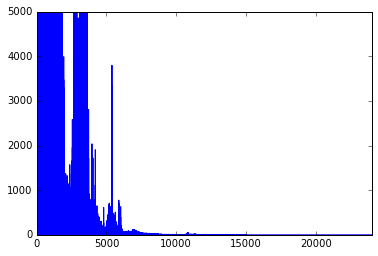

In [146]:
f, Pxx_den = signal.periodogram(rawDataset[names[0]][:,0], Fs)
plt.plot(f, Pxx_den,'b')
plt.xlim((0,24000))
plt.ylim((0,5000))

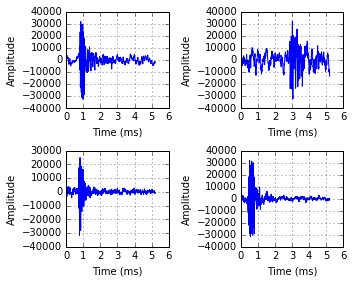

In [14]:
goodOnes = [12,15,20,22]

fig = plt.figure(figsize = (5,4))

for ii in range(len(goodOnes)):
    #audio.play_sound(Fs,clips[goodOnes[ii],:])
    plt.subplot(2,2,ii+1)
    plt.plot((100/Fs)*np.linspace(1,len(clips[goodOnes[ii],:]),len(clips[goodOnes[ii],:])),clips[goodOnes[ii],:],'b')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.grid()
    
fig.tight_layout()  

plt.savefig('snippets.pdf',format = 'pdf', transparent = True)

In [15]:
np.concatenate([np.zeros(offsets['cropped']),croppedDataset[names[0]][:,0]]).shape

(2509051,)

In [ ]:
sDataset = autoS.sync_dataset(cDataset,names)

Now it 

In [ ]:
rawDataPath = os.path.join(os.pardir,'rawData')
files = glob.glob(os.path.join(rawDataPath,'*.wav'))
names = []
        
for name in files:
    fileName = os.path.basename(name).split(".")[0]
    names.append(fileName)

# Applies filter to camera names and returns only selected subset names
audioFiles = pp.getKeys(names,filt);

# Reads the .wav files from the list generted by getKeys
(names,cDataset) = pp.readWAV(rawDataPath,audioFiles);